In [13]:
import os
import numpy as np

import matplotlib.pyplot as plt
from skimage.io import imshow

import skimage.measure

import deepcell.datasets
from deepcell import metrics

# Load data

In [4]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

6370107392/6370099814 [==============================] - 136s 0us/step
X.shape: (5760, 216, 256, 1)
y.shape: (5760, 216, 256, 1)


# Instantiate model from saved weights

First instantiate a model from the deepcell `model_zoo`.

In [7]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=61,
    n_skips=3,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple(X_train.shape[1:]),
    last_only=False)

Compile the model and load weights from a previously trained model.

In [8]:
from tensorflow.keras.optimizers import SGD

fgbg_model.compile(SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),metrics=['accuracy'])
fgbg_model.load_weights('/models/conv_fgbg_model.h5')

# Generate predictions from test data

In [20]:
predict = fgbg_model.predict(X_test)[-1]

Use `skimage.measure.label` to identify discrete objects (nuclei) in the prediction data.

In [32]:
predict_lbl = skimage.measure.label(predict[:,:,:,1]>0.5, connectivity=2)

Visualize the image at each stage in processing.

1194


Text(0.5, 1.0, 'Labeled Truth')

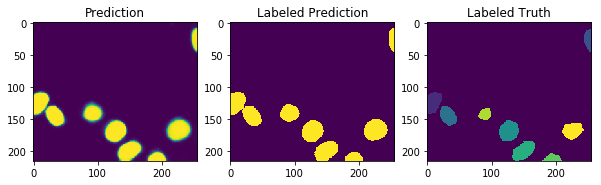

In [33]:
# Select a random sample to view
i = np.random.randint(0,high=1440)
print(i)

fig,ax = plt.subplots(1,3,figsize=(10,8))
ax[0].imshow(predict[i,:,:,1])
ax[0].set_title('Prediction')
ax[1].imshow(predict_lbl[i,:,:])
ax[1].set_title('Labeled Prediction')
ax[2].imshow(y_test[i,:,:,0])
ax[2].set_title('Labeled Truth')

# Run metrics

Deepcell's metrics for assessing model accuracy take in two arrays as inputs:
1. A 3D array (sample,x,y) containing the labeled ground truth annotation data
2. A 3D array (sample,x,y) containing the labeled prediction data.

## Pixel Based

The first metric assess accuracy on a pixel by pixel basis. This does not help us assess the accuracy of our model in terms of nuclear classification.

In [35]:
metrics.stats_pixelbased(y_test[:,:,:,0],predict_lbl)


____________________Pixel-based statistics____________________

Dice: 0.9012
Jaccard: 0.8202

Precision: 0.8412
Recall: 0.9704
F-measure: 0.9012


The statistics in used in this function are calculated as follows given the true labels ($T$) and predicted labels ($P$):
$$ \text{Dice} = \frac{2|T\cap P|}{|T|+|P|} $$

$$ \text{Jaccard} = \frac{|T\cap P|}{|T\cup P|} $$

$$ \text{Precision} = \frac{|T\cap P|}{|P|} $$
$$ \text{Recall} = \frac{|T\cap P|}{|T|} $$
$$ \text{F-Measure} = \frac{2\ast\text{Precision}\ast\text{Recall}}{\text{Precision}+\text{Recall}} $$

## Object Based

The corresponding function to test object-based accuracy typically takes longer to run.

In [41]:
metrics.stats_objectbased(y_test[:100,:,:,0],predict_lbl[:100])


____________________Object-based statistics____________________

Intersection over Union thresholded at 0.5 for object detection
Dice/F1 index: 0.9034
Jaccard index: 0.8238
Number of cells predicted: 639
Number of cells present in ground truth: 667
Accuracy: 82.7586%

#false positives: 87	% of total error: 52.4096	% of predicted incorrect: 13.615
#false negatives: 79	% of total error: 47.5904	% of ground truth missed: 11.8441
#incorrect merges: 35	% of ground truth merged: 5.2474
#incorrect divisions: 1	% of ground truth divided: 0.1499


Objects are determined to be a match if their Jaccard score was greater than 0.5. The statistics displayed above were calculated with the following terms: false positives ($FP$), false negatives ($FN$), and true positives ($TP$).